In [1]:
!pip install numpy gymnasium wandb matplotlib
import numpy as np
import gymnasium as gym
import wandb
import random
from collections import defaultdict

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    return seed

# Discretize the continuous state space for MountainCar
class StateDiscretizer:
    def __init__(self, n_bins=25):  # Increased from 20 to 25 bins
        self.n_bins = n_bins
        # MountainCar-v0 state space bounds
        self.position_bins = np.linspace(-1.2, 0.6, n_bins)
        self.velocity_bins = np.linspace(-0.07, 0.07, n_bins)

    def discretize(self, state):
        position, velocity = state

        # Discretize each dimension
        position_bin = np.digitize(position, self.position_bins)
        velocity_bin = np.digitize(velocity, self.velocity_bins)

        # Combine into a single discrete state
        return (position_bin, velocity_bin)

# SARSA Agent with epsilon-greedy exploration
class SARSAAgent:
    def __init__(self, state_discretizer, action_space, alpha=0.2, gamma=0.99, epsilon=0.1):  # Changed alpha from 0.1 to 0.2
        self.state_discretizer = state_discretizer
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))

    def select_action(self, state):
        state = self.state_discretizer.discretize(state)

        # Epsilon-greedy policy
        if np.random.random() < self.epsilon:
            return self.action_space.sample()  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update(self, state, action, reward, next_state, next_action, done):
        state = self.state_discretizer.discretize(state)
        next_state = self.state_discretizer.discretize(next_state)

        # SARSA update rule
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * self.q_table[next_state][next_action]

        # Update Q-value
        self.q_table[state][action] += self.alpha * (target_q - current_q)

# Q-Learning Agent with Softmax exploration
class QLearningAgent:
    def __init__(self, state_discretizer, action_space, alpha=0.2, gamma=0.99, temperature=0.8):  # Changed alpha from 0.1 to 0.2, temperature from 1.0 to 0.8
        self.state_discretizer = state_discretizer
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))

    def select_action(self, state):
        state = self.state_discretizer.discretize(state)

        # Softmax exploration
        q_values = self.q_table[state]
        exp_q = np.exp(q_values / self.temperature)
        probabilities = exp_q / np.sum(exp_q)

        # Sample action based on probabilities
        return np.random.choice(self.action_space.n, p=probabilities)

    def update(self, state, action, reward, next_state, done):
        state = self.state_discretizer.discretize(state)
        next_state = self.state_discretizer.discretize(next_state)

        # Q-Learning update rule
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state])

        # Update Q-value
        self.q_table[state][action] += self.alpha * (target_q - current_q)

# Training function for SARSA
def train_sarsa(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Fixed seeds
        seeds = [42, 123, 456, 789, 101]
        all_final_rewards = []

        for seed in seeds:
            # Set environment
            env = gym.make("MountainCar-v0")

            # Set random seed
            set_seed(seed)

            # Initialize state discretizer
            state_discretizer = StateDiscretizer(n_bins=config.n_bins)

            # Initialize SARSA agent
            agent = SARSAAgent(
                state_discretizer=state_discretizer,
                action_space=env.action_space,
                alpha=config.alpha,
                gamma=config.gamma,
                epsilon=config.epsilon
            )

            # Training loop
            episode_rewards = []

            for episode in range(config.n_episodes):
                state, _ = env.reset(seed=seed + episode)
                action = agent.select_action(state)
                done = False
                episode_reward = 0

                while not done:
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    # Apply enhanced reward shaping
                    shaped_reward = reward
                    if config.use_reward_shaping:
                        position, velocity = next_state

                        # Reward for moving toward the goal (right side)
                        shaped_reward = reward

                        # Reward for gaining momentum (either direction)
                        shaped_reward += 0.1 * abs(velocity)

                        # Reward for position improvement
                        shaped_reward += 0.1 * position

                        # Additional reward for coordinated actions (moving right and pushing right)
                        if velocity > 0 and action == 2:
                            shaped_reward += 0.2

                        # Additional reward for coordinated actions (moving left and pushing left)
                        if velocity < 0 and action == 0:
                            shaped_reward += 0.2

                        # Bonus for reaching the goal
                        if terminated and position >= 0.5:
                            shaped_reward += 10

                    episode_reward += shaped_reward

                    # Select next action using current policy
                    next_action = agent.select_action(next_state)

                    # Update Q-values
                    agent.update(state, action, shaped_reward, next_state, next_action, done)

                    # Move to next state and action
                    state = next_state
                    action = next_action

                episode_rewards.append(episode_reward)

                # Log individual seed performance
                wandb.log({
                    f"seed_{seed}_episode": episode,
                    f"seed_{seed}_reward": episode_reward,
                })

            # Store final performance (avg of last 50 episodes)
            final_reward = np.mean(episode_rewards[-50:])
            all_final_rewards.append(final_reward)
            env.close()

        # Calculate average performance across all seeds
        avg_final_reward = np.mean(all_final_rewards)

        # Log the average performance
        wandb.log({
            "average_reward_across_seeds": avg_final_reward
        })

        return avg_final_reward

# Training function for Q-Learning
def train_qlearning(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Fixed seeds
        seeds = [42, 123, 456, 789, 101]
        all_final_rewards = []

        for seed in seeds:
            # Set environment
            env = gym.make("MountainCar-v0")

            # Set random seed
            set_seed(seed)

            # Initialize state discretizer
            state_discretizer = StateDiscretizer(n_bins=config.n_bins)

            # Initialize Q-Learning agent
            agent = QLearningAgent(
                state_discretizer=state_discretizer,
                action_space=env.action_space,
                alpha=config.alpha,
                gamma=config.gamma,
                temperature=config.temperature
            )

            # Training loop
            episode_rewards = []

            for episode in range(config.n_episodes):
                state, _ = env.reset(seed=seed + episode)
                done = False
                episode_reward = 0

                while not done:
                    action = agent.select_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    # Apply enhanced reward shaping
                    shaped_reward = reward
                    if config.use_reward_shaping:
                        position, velocity = next_state

                        # Reward for moving toward the goal (right side)
                        shaped_reward = reward

                        # Reward for gaining momentum (either direction)
                        shaped_reward += 0.1 * abs(velocity)

                        # Reward for position improvement
                        shaped_reward += 0.1 * position

                        # Additional reward for coordinated actions (moving right and pushing right)
                        if velocity > 0 and action == 2:
                            shaped_reward += 0.2

                        # Additional reward for coordinated actions (moving left and pushing left)
                        if velocity < 0 and action == 0:
                            shaped_reward += 0.2

                        # Bonus for reaching the goal
                        if terminated and position >= 0.5:
                            shaped_reward += 10

                    episode_reward += shaped_reward

                    # Update Q-values
                    agent.update(state, action, shaped_reward, next_state, done)

                    # Move to next state
                    state = next_state

                episode_rewards.append(episode_reward)

                # Log individual seed performance
                wandb.log({
                    f"seed_{seed}_episode": episode,
                    f"seed_{seed}_reward": episode_reward,
                })

            # Store final performance (avg of last 50 episodes)
            final_reward = np.mean(episode_rewards[-50:])
            all_final_rewards.append(final_reward)
            env.close()

        # Calculate average performance across all seeds
        avg_final_reward = np.mean(all_final_rewards)

        # Log the average performance
        wandb.log({
            "average_reward_across_seeds": avg_final_reward
        })

        return avg_final_reward

# Sweep configuration for SARSA
sarsa_sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'average_reward_across_seeds',
        'goal': 'maximize'
    },
    'parameters': {
        'alpha': {
            'min': 0.1,
            'max': 0.2
        },
        'gamma': {
            'value': 0.99  # Fixed as recommended
        },
        'epsilon': {
            'min': 0.05,
            'max': 0.2
        },
        'n_bins': {
            'values': [20, 25, 30]
        },
        'n_episodes': {
            'value': 3000
        },
        'use_reward_shaping': {
            'value': True
        }
    }
}

# Sweep configuration for Q-Learning
qlearning_sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'average_reward_across_seeds',
        'goal': 'maximize'
    },
    'parameters': {
        'alpha': {
            'min': 0.1,
            'max': 0.3
        },
        'gamma': {
            'value': 0.99  # Fixed as recommended
        },
        'temperature': {
            'min': 0.5,
            'max': 1.0
        },
        'n_bins': {
            'values': [20, 25, 30]
        },
        'n_episodes': {
            'value': 3000
        },
        'use_reward_shaping': {
            'value': True
        }
    }
}


# Initialize and run the SARSA sweep
def run_sarsa_sweep():
    sweep_id = wandb.sweep(sarsa_sweep_config, project="RL_MountainCar_SARSA")
    wandb.agent(sweep_id, function=train_sarsa, count=20)

# Initialize and run the Q-Learning sweep
def run_qlearning_sweep():
    sweep_id = wandb.sweep(qlearning_sweep_config, project="RL_MountainCar_QLearning")
    wandb.agent(sweep_id, function=train_qlearning, count=20)




In [2]:
import wandb
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abhijithvinod (abhijithvinod-indian-institue-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Run the sweeps
if __name__ == "__main__":
    run_sarsa_sweep()


Create sweep with ID: bfmad29r
Sweep URL: https://wandb.ai/abhijithvinod-indian-institue-of-technology-madras/RL_MountainCar_SARSA/sweeps/bfmad29r


wandb: Agent Starting Run: ynyv82j2 with config:
wandb: 	alpha: 0.24096302498757816
wandb: 	epsilon: 0.09608690670112062
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
seed_101_reward,▁▁▁▁▁▅▄▆▄▆▇▃▅▄▂▂█▆▆▅▃▆█▆▅▅▃▄▄█▃█▆▅▃▄▂▄▂█
seed_123_episode,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
seed_123_reward,▁▁▁▁▁▅▂▂▂▁▃▁▆▁▇▅▂▂▅▂▆▅▅▃▅▂▂▃▅▃▆▅▅▅█▅▅▆▅▆
seed_42_episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇██████
seed_42_reward,▁▁▁▁▁▄▁▁▁▂▁▂▂▁▃▄▆▂▁▁▄▆▃▅▆▅▁▂▂▆▃▄▂▅▆▃▁▆▅█
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██████
seed_456_reward,▁▁▁▁▁▁▁▂▃▂▅▃▁▃▅█▂▅▆▃▂▄▆▆▂▆▆▃▃▂▄▆▆▃▅█▅█▂▅
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
seed_789_reward,▁▅▁▁▁▁▁▁▂▅▁▆▄▂▅▆▃▃▂▂▇▆▇█▃▂▆▂█▆▇▂▇▃▂▁▅█▄▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldzehu5y with config:
wandb: 	alpha: 0.2516841428628418
wandb: 	epsilon: 0.1179327679593104
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
seed_101_reward,▁▁▁▁▁▁▂▁▃▁▃▁▃▁▅▅▂▃▁▃▃▆▆▁█▂▃▅▅▆▆▆▆▁▃▃▇▂▅▃
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇███████
seed_123_reward,▁▁▁▁▁▁▁▁▁▂▂▂▁▁▅▅▁▅▆▆▁▅▁▅▄▂▆▅▆▅▃▆▄▄▆▁▆█▂▅
seed_42_episode,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▁▂▃▃▄▆▄▅▂▇▅▄▅▃▃▆▃▅▅▅▆█▅▅
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
seed_456_reward,▁▁▁▄▁▄▄▄▁▁▂▂▅▅▅▅▅▅▅▅▅▅▅▅▁▃▆▃▅█▅▅▁▅▅▆█▆▆▅
seed_789_episode,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
seed_789_reward,▁▁▁▂▂▆▂▂▂▆▃▂▆▂▄▇▂▃▂▆▇▆▆▆▇▂▄▃▇▂▃▂█▆▃▂▂▃▄▄


wandb: Agent Starting Run: 5xh6gpru with config:
wandb: 	alpha: 0.10940523159888071
wandb: 	epsilon: 0.1645143805222924
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
seed_101_reward,▁▁▁▁▁▅▂▂▁▂▁▃▁▁▃▆▅▂▂▂▂▅▅▂▃▆▆▅▅▄▆▆▆▅▂██▂▅▃
seed_123_episode,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
seed_123_reward,▁▁▁▅▁▅▄▁▂▂▂▅▅▇▃▂▁▃▂▆▁▅▅▃▁▅▅▅▅█▆▅▅▂▃▅▃▅▇▇
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▁▁▁▇▄▅▂▅▂▅▄▁▂▂▁▅▅▅█▅▃▁▅▂▃▄▃▁▁▂▂▂▅▁▆
seed_456_episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
seed_456_reward,▁▁▁▁▁▁▅▁▁▁▄▂▁▁▁▂▁▃▅▂▂▄▃▂▅█▁▁▆▂▄▁▂▅▁▆▅▁▅▁
seed_789_episode,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇█
seed_789_reward,▁▁▁▁▁▁▂▁▂▂▁▂▆▅▂▆▆▄▂▂▂▅▂▆▂▂▂▅▇▄▇█▇█▃▄▂█▇▇


wandb: Agent Starting Run: 8hxudrfd with config:
wandb: 	alpha: 0.11220784761878116
wandb: 	epsilon: 0.1695384826890194
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
seed_101_reward,▁▁▁▁▁▁▁▅▁▁▁▁▁▅▇▁▃▆▁▃▆▃▆▆▇▁▂▂▁▂▆▇▆▇█▇▇▇▇▁
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
seed_123_reward,▁▁▁▁▁▁▂▁▁▂▁▁▄▂▃▂▄▁▆▅▅▁▅▅▂▁▅▆▂▂▃▅▅▄▅▃█▅▅▃
seed_42_episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇████
seed_42_reward,▁▁▁▁▂▂▁▃▆▂▄▄▇▄▃▁▇▃▆▃▇▃█▂▆▇▆▆▆▇▂▃▂█▃▂▆▅▃█
seed_456_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
seed_456_reward,▁▁▁▁▁▁▁▁▂▃▁▁▁▁▆▂▂▆▂▆▄▆▃▆▆▅▆▅█▂▄▁▆▅▂▂▃▅▆▇
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
seed_789_reward,▁▁▁▁▁▁▁▁▃▁▁▁▂▂▂▁▁▅▂▂▁▂▂▅▂▅▃▃▅▁▆█▅▂▅▅▅▅▅▇


wandb: Agent Starting Run: 4lt7vefk with config:
wandb: 	alpha: 0.1770432407523055
wandb: 	epsilon: 0.13981970577079
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
seed_101_reward,▁▁▁▁▁▁▁▂▁▁▁▂▂▂▃▂▂▃▃▁▅▂▄▃▂▂▆▅▆▆▃▄▃▄▅▄██▂▆
seed_123_episode,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
seed_123_reward,▁▁▁▁▁▂▂▂▇▂▂▄▁▂▂▂▄▇▃▂▂█▂▃▂▂██▄▇▆▄▄▅▄▂▄███
seed_42_episode,▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
seed_42_reward,▁▁▁▁▁▁▁▁▂▁▂▂▁▅▂▃▂▂▁▄▆▃▂▅▆▆█▂▆▂▂▆▂▃▆▂▅▆▆▃
seed_456_episode,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
seed_456_reward,▁▁▁▂▁▁▁▁▂▁▁▂▅▂▁▂▅▆█▂▅▅▂▆▅▁▃▅▆▂▅▆▆▆█▂▅▂▄▂
seed_789_episode,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
seed_789_reward,▁▁▁▁▁▁▁▁▂▁▁▃▁▂▂▅▁▅▇█▆▅▆▅▃▆▅▃▅▆▂▅▅▅▃▆▃▂▃▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: byzgmzlq with config:
wandb: 	alpha: 0.10163218874966327
wandb: 	epsilon: 0.08575587229444466
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇█████
seed_101_reward,▁▁▁▁▁▁▁▄▁▁▄▅▂▂▂▃▅▃▅▂▅▅█▅▂▁▅▆▂▅▆▃▃▆▁█▇▂▇▂
seed_123_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_123_reward,▁▁▁▁▁▁▁▁▂▂▅▂▅▅▅█▂▄▆▅▃▃█▃▂▁▆▂▅▅▆▅▆▃▆▄▂▆▆▆
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▁▃█▂▆▅▃▅▅▆▃█▃▇▅▅▆▁▆▂▆▂▃▃▆▇▆▃▂
seed_456_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇▇███
seed_456_reward,▁▁▁▁▁▁▁▁▁▁▁▂▁▁▅▁▃▂▆▂▄▅▅▂▆▅▂▂▂▄▃▆█▇█▆▄▄▆▃
seed_789_episode,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
seed_789_reward,▁▁▁▂▁▃▁▄▁▂▂▆▂▂▂▂▅▅▃▇▄█▇▇█▇▂▄▇▂▆█▇▇▂▇█▇▂█


wandb: Agent Starting Run: gesmvirl with config:
wandb: 	alpha: 0.15128481317662185
wandb: 	epsilon: 0.1147818633015786
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇████
seed_101_reward,▁▁▂▁▂▁▁▂▁▁▂▂▃▃▅▂▅▁▂▃▂▃▃▅▃▃▅▂▂▃▅▅█▇▆▅▇▅▅▅
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇█████
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▂▂▄▂▂█▅▆▆▂▂▅▂▆▄▅▆▂▆▆▅▃
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇███
seed_42_reward,▁▁▁▁▁▂▁▂▁▁▁▂▂▁▂▁▁▅▃▂▂▃▂▃▂▂▅▃▅▆█▆▆▂▅▂▄▃▄▆
seed_456_episode,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
seed_456_reward,▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▅▂▂▃▂▄▁▃▅▃▁▃▅▆▂▂▄▄▃▃▆█▄▆
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇████████
seed_789_reward,▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▅▅▂▃▂▂▆▂▂▃▅▅▅▅▅▆▄▄▆▂▃▆▂█


wandb: Agent Starting Run: 0eeleyu3 with config:
wandb: 	alpha: 0.10488543342524066
wandb: 	epsilon: 0.08840683178064657
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
seed_101_reward,▁▁▁▁▁▁▅▂▁▂▂▂▁▅▁▃▃▁▅▅▂▂▃▃█▂▆▅█▅▅▃▄▃▆▂▂█▂▃
seed_123_episode,▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
seed_123_reward,▁▁▂▁▁▁▁▂▂▂▂▂▃▃▂▇▂▂▄▂▄▇▆█▇▆▇▇▆▅▅▄▄▂█▆▇▇▄█
seed_42_episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
seed_42_reward,▁▁▁▁▁▁▄▁▁▂▁▅▁▂▁▂▁▂▁▂▅▃▃▆▅▄▆▁▂█▂▆▁▆▆▆▇▅█▁
seed_456_episode,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
seed_456_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▄▅▂▅▃▄▅▂▄▆▃▃▆▅▅█▅▇▄▂▃▃
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
seed_789_reward,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▅▆▂▅▇▂▂▂▂▅▂▅▅▃█▅▃▅▃▂▅▅▂▂▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cx4cw3g3 with config:
wandb: 	alpha: 0.16915218727971876
wandb: 	epsilon: 0.18707818438154208
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███
seed_101_reward,▁▁▁▁▁▁▂▂▅▂▂▂▂▂▂▆▂▂▇▄▇▆▅▂▂▂▄▄▂▂▇▃▇▇▃█▂▇▆▇
seed_123_episode,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
seed_123_reward,▁▁▂▁▂▁▃▃▆▂▂▂▂▂▂▂▂▂▂▃▂▂▂▆▇█▄▄█▇▄█▃▂▅▇▂▆▂▃
seed_42_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▂▅▂▄▆▄▆▂▆▁▁▃▃▃▄▆▂▃▄▆▃█▆▆▇▇▂▂▂▇▃▆▅▂▃
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
seed_456_reward,▁▁▁▁▁▂▁▂▂▁▁▃▁▃▄▃▅▄▂▃█▆▃▆▅▁▆▅▃▆▅▅▆▆▃▆▃▃▇▆
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_789_reward,▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▂▂▂▂▅▅▃▅▇▄▂▂▂▆▅▆▆▅▃█▅▅▂▃▂


wandb: Agent Starting Run: 4p4y9cun with config:
wandb: 	alpha: 0.23220019398313332
wandb: 	epsilon: 0.09204928934834576
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
seed_101_reward,▁▁▁▅▂▂▂▂▆▅▅▃▄▃▅▅▅█▅▆▂▅▅▆▇▄▅▃▆▅▅▆▆▇▆▇▆▂▂▅
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
seed_123_reward,▁▁▁▁▁▁▄▁▂▁▁▁▅▁▄▁▃▆▂▂█▆▆▁▅▄▅█▅▅▃▆▆▇▃▇▅▅▅▅
seed_42_episode,▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
seed_42_reward,▁▁▁▂▁▁▂▁▁▁▆▅▃▂▄▅▁▃▅▅▅▃▄▅▃▇▆▆▆▆█▂▅▂▃▃▅▆▅█
seed_456_episode,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
seed_456_reward,▁▁▁▁▁▂▁▂▁▂▂▁▂▅▂▃▆▅▆▆▅█▆▃▆▆█▇▂▆▅▁▆▆▇▆▃▆▅▃
seed_789_episode,▁▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
seed_789_reward,▁▁▁▁▁▁▇▃▂▃▄▄▂▂▆▁▃▄▇▇▇▄▄▄▂▆▇▇▆▇██▇▂▇▄███▄


wandb: Agent Starting Run: yabf0vrs with config:
wandb: 	alpha: 0.2736010225774256
wandb: 	epsilon: 0.06533923491402369
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
seed_101_reward,▁▁▁▁▂▂▂▂▃▂▂▆▆▂▂▆▆▆▂▂█▆▆▆▂▆▆▂▄▃▆▄▆▂▆▇▇▃▆▆
seed_123_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
seed_123_reward,▁▁▁▁▁▁▂▂▁▄▂▅▂▂▃▄▅▃▂▆▂▆██▆▄▃▂▂▄▅▄▃▂▃▄▂▆▆▆
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
seed_42_reward,▁▁▁▁▂▁▂▂▂▃▃▁▂▇▄▃▂▆▄▂▄▄█▃▄▂▂▂▅▇▂▄▄█▆▅▆█▇█
seed_456_episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
seed_456_reward,▁▁▁▁▆▆▁▃▂▁▄▄▂▇▂▂▇▆▇▅▆▇▂▆▇█▂▅█▇▇▅▇▂▂▅█▂▂▃
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
seed_789_reward,▁▁▁▁▁▁▅▂▅▂▁▂▂▁▅█▅▄▅▆▅▃▃▆▆▅▂▆▃▅█▆▄▂▆▅▆▄▃▆


wandb: Agent Starting Run: h7ea6gle with config:
wandb: 	alpha: 0.23753070281473576
wandb: 	epsilon: 0.0955443311785133
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
seed_101_reward,▁▁▂▂▁▁▁▄▂▃▃▅▅▅▁▅▅▅▄▅▃▅▆█▆▅▆▅▁▆▃▆▅▃▅▃▆▂▅▂
seed_123_episode,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
seed_123_reward,▁▁▃▁▁▂▁▅▅▁▅▃▅▅▆▄▄▂▆▂▅▆▄▂▄▆▂▂▆▆▆▁▆▂▃▃▆█▆▆
seed_42_episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▁▂▁▄▃▂▂▃▅▅▅█▄▄▅▃▃▅▅▄▆▄▃▅▅▆▆▆▅▅▅▇▆▆█
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
seed_456_reward,▁▁▁▁▁▁▁▁▂▅▅▂▄▇▇▁▅▆▅▃▃▄▇▇▂▅▄▇▆▂▇▇▇▇▄▃▄▂▅█
seed_789_episode,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
seed_789_reward,▁▁▁▁▂▂▄▁▁▃▁▄▃▄▁▅▅▆▅▂▂▅█▄▅▆▅▅▅▂▁▅▆▄▄▁▅▅▅▆


wandb: Agent Starting Run: diqaibln with config:
wandb: 	alpha: 0.10724286563046775
wandb: 	epsilon: 0.13396238245908232
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇██
seed_101_reward,▁▁▁▁▁▂▂▁▇▆▂▃▂▆▂▄▆▆▂█▆▇▃▂▂▂▅▅▇▆█▃▇▇▃█▇▄▄▂
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
seed_123_reward,▁▁▁▁▁▅▁▁▁▁▅▇▅▅▅▂▆▃▆▁▃▂▂▆▂▂▃▆▆▆▆▆▂█▅▃▂▆▃▆
seed_42_episode,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▃▃▅█▃▅▁▂▃▃▂▆▂▆█▁▆▆▅▆▅▅▆▆
seed_456_episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
seed_456_reward,▁▁▂▁▁▁▁▁▂▂▁▂▁▂▂▂▂▃▂▂█▆▆▆▆▇▇▂▂▅▆▆▆▆▆▇▇▇▅▂
seed_789_episode,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███████
seed_789_reward,▁▁▁▂▄▁▅▅▆▃▆▅▁▃▆▆▅▆▅▅█▆▆▄▁▇▆▇▃▆▃▅▆█▃▅▂▆▂▆


wandb: Agent Starting Run: 4fg85mn2 with config:
wandb: 	alpha: 0.10773974626425133
wandb: 	epsilon: 0.13758889023694987
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
seed_101_reward,▁▁▂▂▂▂▂▁▂▂▂▂▁▂▂▂▆▂▃▇▂▂▇▂▂▂▄▇█▂▆▇▇▇▄▇▇▇█▂
seed_123_episode,▁▁▁▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▁▁▂▂▄▂▂▂▂▂▂▇▂▄▄█▂█▇▇▂█▄
seed_42_episode,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
seed_42_reward,▁▁▁▁▁▂▁▁▁▁▂▂▂▁▂▁▂▁▃▂▂▇▂▆▁▁▁▇▃▂▆▂█▂▂▅▁▂█▇
seed_456_episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
seed_456_reward,▁▁▁▁▁▁▁▂▁▃▁▁▁▂▂▁▂▃▆▁▃▂▃▂▅▃▃▆▅▁▃▂█▂▆▃▂▄▆█
seed_789_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
seed_789_reward,▁▁▁▁▁▁▁▂▁▁▂▅▂▁▂▂▄▃▂▅▂▂▃▂▅▅▂▂▂▅▁▃▆▂▅▂▅▆▆█


wandb: Agent Starting Run: echmcq4a with config:
wandb: 	alpha: 0.2613776318613942
wandb: 	epsilon: 0.05141384278362447
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
seed_101_reward,▁▁▁▁▁▂▁▁▃▅▂▂▁▂▂▃▅▃▄▆▄▅▆▆▆▆▆▄▆▅▆▆▇▆▃▆█▂▆▇
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▂▃▅▂▂▂▅▃▃▅▃█▅▃▅▂█▅▅▅█▅▄▆▆▆█▆▆▆
seed_42_episode,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
seed_42_reward,▁▁▁▁▂▁▅▃▂▁▁▂▂▂▃▁▃▅▂▂▆▄▆▆▁▅▅▄▅▅█▇█▆▅▆▃▄▅▆
seed_456_episode,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
seed_456_reward,▁▁▁▁▁▁▁▁▁▂▃▂▂▆▂▄▆▅▃▆▅█▃▄▆▅▆▄▃▆▇▅▄▆▆▇▃▆▆▇
seed_789_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
seed_789_reward,▁▁▁▁▂▂▂▂▁▁▂▅▅▃▂█▆▆▆▆▄▅▆▆▄▂▆▃▆▆█▆▃▅▅▇▆▃▃▃


wandb: Agent Starting Run: wc7vua5w with config:
wandb: 	alpha: 0.197528871493594
wandb: 	epsilon: 0.11888402553828648
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇███
seed_101_reward,▁▁▁▂▁▃▁▂▁▂▁▅▁▂▃▆▄▅▂▅▄▅▆▄▃▁▃▄▅▂▆▃▃▆▅▆▇█▆▃
seed_123_episode,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
seed_123_reward,▁▁▁▁▄▂▁▁▃▅▂▄▅▅▂▃▃▁▃▂▂▅█▅▅▆▂▂▆▅▃▅▅█▅▅▂▆▄▃
seed_42_episode,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
seed_42_reward,▁▁▁▁▁▁▁▄▄▁▁▅▅▆▂▅▄▁▅▅▂▆▂▄▆▄▅▇▅▄▆▄▅▆▃▃▆▆▆█
seed_456_episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
seed_456_reward,▁▁▁▅▁▁▁▁▁▁▃▁▅▁█▆▆▆▅▁▁▃▆▃▁▆▁▄▃▁▆▄▆▃▆▆▆▅▆▆
seed_789_episode,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
seed_789_reward,▁▁▁▁▁▃▂▁▅▁▁▆▁▃▂▆▆▆▆▇▆▇▆▂▆▁▂▅▂▅▃▅▃▆▂▇▆▇▆█


wandb: Agent Starting Run: 109wnxzf with config:
wandb: 	alpha: 0.13134262473312688
wandb: 	epsilon: 0.10655818709684128
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇█████
seed_101_reward,▁▁▁▁▁▁▁▁▂▄▁▂▅▂▂▂▃▂▂▁▃▃▂▂▅▄▅▂▆█▂▅▆▅▆▆▅▃▆▆
seed_123_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
seed_123_reward,▁▁▁▁▁▁▁▂▂▁▁▅▄▂▁▆▂▅▄▅▂▆█▇▂▃▃▆▅▁▄▅▅▄▃▆▂▂██
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
seed_42_reward,▁▁▁▁▁▁▅▂▄▁▁▂▁▂▆▁▂▃▆▂▁▅▆█▆▅▄▃▂▆▆▃▄▆▆▄▂▁▆▆
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
seed_456_reward,▁▁▁▂▁▁▂▂▂▂▂▂▂▂▄▃▂▂▃▄▂▅▆▂▂▂▆▃▄▄▅▆▂█▃▂▆█▅▆
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
seed_789_reward,▁▁▁▁▁▁▁▁▂▁▁▁▁▂▃▂▂▂▃▂▄▃▃▄▂▅▆█▄▆▅▆▆▆▆▇▆▃▆▃


wandb: Agent Starting Run: dwjdh510 with config:
wandb: 	alpha: 0.2334901405748856
wandb: 	epsilon: 0.184068910289126
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇████
seed_101_reward,▁▁▁▁▁▁▁▁▂▂▁▁▇▂▁▆▄▇▁▇▂▇▂▇▁▇▃▄▇▁▄▁▇█▇▇██▂▆
seed_123_episode,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
seed_123_reward,▁▂▁▂▂▂▃▁▁▂▆▆▇▂▂▄▂▇▅▄▄▂▆▂▆▇▆▆▂█▂▇▇▆▂▅▂▅▆█
seed_42_episode,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
seed_42_reward,▁▂▂▁▂▂▇▇▆█▂▆▂▆▇▄▄▄▂▂▇▄▆▂▇▇▂▂▆█▂▂▆▆▂▂▄▇▃▆
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇███████
seed_456_reward,▁▁▂▁▁▂▄▃▁▁▄█▁█▃▂▆▇▇▇█▂▇▁██▇▂▇█▇▃▃▅▆▃▂█▇▇
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
seed_789_reward,▁▁▁▁▁▂▁▂▂▁▅▁▂▂▂▂▃▃▆▆▅█▇▇█▄█▇▇▂█▇▂▂▄█▄▂▃▇


wandb: Agent Starting Run: b3s5z59n with config:
wandb: 	alpha: 0.1272430246152541
wandb: 	epsilon: 0.10419610563803168
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇███
seed_101_reward,▁▁▁▁▁▁▁▂▁▁▁▂▂▂▂▂▄▁▂▂▁▆▂▃▆▁▅▂▆▆▂▆▆▅▆▃▆█▅▇
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▃▁▁▂▁▃▂▅█▄▇▅▅▄▅▂▆▆▆▂▃▁
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
seed_42_reward,▁▁▁▁▁▂▂▁▂▅▁▃▅▁▂▂▃▁▃▅▂▃▂▂▂▆▂▃▃▂▄█▂▆▄▇▆▆▁▆
seed_456_episode,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
seed_456_reward,▁▁▁▁▁▁▂▁▂▁▅▂▂▁▆▂▆▄▇▇▂▂▇▂▇▆▂▂▆█▂▆▇▁▄▇▇█▃▇
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_789_reward,▁▁▁▁▂▂▂▂▁▂▂▂▂▁▂▇▂▂▂▂▃▂▂▂▅▂▂▆▂▆▇▄▄▇▇▃██▆▇


wandb: Agent Starting Run: entjc35y with config:
wandb: 	alpha: 0.22987421252257487
wandb: 	epsilon: 0.17233237594285167
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	use_reward_shaping: True


wandb: Ctrl + C detected. Stopping sweep.


In [3]:
run_qlearning_sweep()

Create sweep with ID: wb4w3b61
Sweep URL: https://wandb.ai/abhijithvinod-indian-institue-of-technology-madras/RL_MountainCar_QLearning/sweeps/wb4w3b61


wandb: Agent Starting Run: y76yn2sc with config:
wandb: 	alpha: 0.23373089002431255
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7427537964588857
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
seed_101_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▁▁▁▄▁▁▁▁▃▃▆█▄▄▂▄▄▁
seed_123_episode,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
seed_123_reward,▁▁▁▁▁▁▂▂▂▂▂▂▇▂▁▂▂▂▂▂▂▄▃▂▇▇█▄▃▂▂▂▂▂▇▇▇▅▁▇
seed_42_episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
seed_42_reward,▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▁▁▂▁▁▂▂▁▁▂▆▂▂▇▆▇▅▁▁▁▃▁▁██
seed_456_episode,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
seed_456_reward,▁▁▂▁▁▁▁▄▂▂▁▂▂▁▆▂▂▃▃▇▂▇▂▃▂▂▁█▂▂▆▂▇▂▂▁▂▆▇▁
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
seed_789_reward,▁▁▁▁▂▁▂▁▂▁▂▂▂▂▂▁▂▁▂▂▂▇▂▁▂▆▂▆▆█▆▆▁▁▆▃▄▂▅▅


wandb: Agent Starting Run: mam0er28 with config:
wandb: 	alpha: 0.23607474651530305
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.9977774493236796
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
seed_101_reward,▃▁▃▄▅▄▃▆▃▄▆▄▃▇▆▅▅▅▄▅▇▆▂▆▅▄▇█▄▆▄▆▇▆▅▄▆▄▅▆
seed_123_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
seed_123_reward,▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▁▂▅▂▂▂▂▂▁
seed_42_episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
seed_42_reward,▃▃▃▃▁▃▄▅▄▄▄▅▅▃▃▅▃▅▆▅▅▄▃▆▆▄▅▆▇▄▇▅█▇▇▆▇█▄█
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_456_reward,▃▂▁▃▃▅▅▇▅▄▄▅▄▄▃▅▄▄▄▆▄▅▆▆▁▇▇▅▅▇▅▅▅▅▄▆▆▆█▅
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
seed_789_reward,▁▁▂▁▂▁▁▂▂▂▂▁▂▂▂▁▂▃▂▁▁▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▂▃▁█


wandb: Agent Starting Run: vb60p2nj with config:
wandb: 	alpha: 0.11255877118170146
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.6303667032026474
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
seed_101_reward,▁▂▁▁▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂█▃▂▂▇
seed_123_episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▄▂▂▁▇▁▂▃█▂▂▂▂▂▂▁▂▂▂▅▄▆▂
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
seed_42_reward,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂█▂▂▂▁█▂▂▂▂▂▃▂▂▂
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
seed_456_reward,▁▁▁▁▂▂▂▁▂▂▃▁▂▂▂▂▁▇▂▂▂█▂▂▂▁▂▂▂▁▁▁▂▂▂▂▄▂▂▂
seed_789_episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
seed_789_reward,▁▁▁▂▁▁▂▂▁▁▁▁▂▂▁▂▂▂█▁▂▂▁▂▂▂▂▇▂▃▆▂▂▂▂▇▂▂▄▄


wandb: Agent Starting Run: 8hq8ugua with config:
wandb: 	alpha: 0.22310522420450996
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7487458789309913
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇█████
seed_101_reward,▁▁▁▂▁▁▁▂▁▁▂▂▂▂▆▂▂▂▂▂▁▇▁▂█▂▅▁▂█▂▂▂▂▂▅▆▂▇▂
seed_123_episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇███
seed_123_reward,▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▅▃▃▄▂▁▅▂▁▂▂▁▇█▄▄▅▃
seed_42_episode,▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▁▁▂▅▁▅▁▁▁█▅▁▃▂▃▁▂▅▅▁▅█▁
seed_456_episode,▁▁▁▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_456_reward,▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▄▆▂▇▂▃▂▂█▇▅▂▂▂▂▂▂▁▂▇▇▆▂▂▂
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
seed_789_reward,▁▁▂▂▂▁▂▂▂▆▂▂▇▂▇▂▂▂▂▂▂▂▇▇▇██▇▂▆▆▂▂▃▃▂▆▇█▇


wandb: Agent Starting Run: i4hyaoi5 with config:
wandb: 	alpha: 0.19705235292945783
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7926276171425877
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
seed_101_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▆▇▁▁▁▂▂▂▁▁▄██▁▂▁▁▁▆▆█▇▁▂▄
seed_123_episode,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
seed_123_reward,▁▁▁▂▁▁▂▁▂▂▂▂▂▂▃▁▂▂▂▂▁▄▂▄▂▁▂▄▂▂▂▂▂▂▄▅█▂▆▅
seed_42_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
seed_42_reward,▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂█▂▂▂▂▂▁█▁▂▂▃▂▂▂▄▂▄▂▇▂▂▆▁
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
seed_456_reward,▁▁▂▁▁▂▂▂▂▁▂▂▁▂▁▁▂▂▂▂▆▂▂▂▂█▆▁▂▁▆▅▂▆▂▇▁▆█▁
seed_789_episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
seed_789_reward,▁▁▁▁▁▁▂▂▂▁▁▂▁▃▂▁▂▂▂▁▂▄▁▅▂█▂▂▁▁█▂▂▂▄▆▂█▂▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fjg8d9ft with config:
wandb: 	alpha: 0.21764270044638645
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.6835527819737157
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇█████
seed_101_reward,▁▁▁▁▁▁▂▂▁▂▂▁▂▂▂▂▂▁▆▂▂▂▂▂▁▂▃▂▄▆▂▁█▂▂▂▂▂▂▆
seed_123_episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▁▁▃▄▂▂▂▃▂▁▁▁▁▄▆▃▁█▆▁▅▁
seed_42_episode,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
seed_42_reward,▁▁▁▁▂▁▂▂▂▂▂▂▇▄▂▃▇█▂▇▁▂▇▁▂▂▁▂▂▇▂▂▂▁▂▂▆▃▇█
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
seed_456_reward,▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▁▆▂▂▂▂▂▂▁▂▂▂▂▂▂▂█▆▁▁▂▂▂▂
seed_789_episode,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██████
seed_789_reward,▁▂▁▁▁▂▂▁▁▁▁▁▆▁▂▁▂▂▁▂▂▁▂▂▂▂▄▁▂▁▄▁▁▂▂▂▄▁▇█


wandb: Agent Starting Run: xtk77zto with config:
wandb: 	alpha: 0.2257769094971626
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7210248944341484
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
seed_101_reward,▁▁▁▂▁▁▁▂▁▁▂▂▆▂▂▂▄▆▁▄▄▇▇▆▂▆▇▂▇▆▂▂▅▆▇█▇█▇▂
seed_123_episode,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
seed_123_reward,▁▁▁▂▂▁▂▁▂▁▂▂▆▂▂▂█▂▄▆▂▇▇▂▇▇▂▄▂▃▂▂▇▇▂▂▂▇▂▇
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▅▂▄▃▁▄▁▂▆█▅▆▇▆▅▆▆▆▆▄▂▄▄
seed_456_episode,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
seed_456_reward,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▁▆▂▂▂▁▃▆█▂▆▇▁▄▇▁▂▂▃▃█▂▇▂▄
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
seed_789_reward,▁▁▁▁▁▁▁▁▁▂▁▃▂▂▁▁▁▂▅▅▄▁▂▂▁▁▁▁▂▆▁▅▃▃▂▂▄█▅▅


wandb: Agent Starting Run: kv93xim6 with config:
wandb: 	alpha: 0.2241875848102633
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7752747230449084
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
seed_101_reward,▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▄▁▃▅▂▁▂▅▃▅▁▆▁█▆▂▆▆▁▃▂▃▅▃▂
seed_123_episode,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
seed_123_reward,▁▁▁▁▁▁▁▁▂▁▁▂▁▂▆▁▂▁▂▁▂▂▁▁▁█▁▃▂▇▂█▁▂▅▂█▆▃▁
seed_42_episode,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
seed_42_reward,▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▆▂▆▁▂▂▁▂▄▇▁▁▆▂▃▄▂█▂▇▆█▂▆
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
seed_456_reward,▁▁▂▁▁▁▁▂▂▆▁▂▁▂▂▁▁▇▂▂▆▂▂▃█▁▂▄▁▁▆▂▁▃▁█▁▂▇▆
seed_789_episode,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
seed_789_reward,▁▁▁▁▁▁▂▁▁▁▂▁▁▂▅▃▁▁▁▃▁▂▁▁▅▂▆▃▁▁▁▅▁▂▅▁▄▁██


wandb: Agent Starting Run: pubhemas with config:
wandb: 	alpha: 0.11939984165003986
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.9879421197028568
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
seed_101_reward,▁▃▄▃▄▄▆▃▆▅▂▄▄▄▅▅▃▄▅▆▄▄▅▆▄▆▅▅▇▆▅▇▅▆▄▆▆▇█▅
seed_123_episode,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
seed_123_reward,▁▂▁▂▁▃▂▂▁▂▂▃▂▂▃▂▃▁▂▂▂▂▃▂▂▁▂▃▂▂▂▂▂█▂▃▁▄▂▁
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
seed_42_reward,▃▂▃▅▂▁▂▃▂▄▄▅▄▆▄▆▅▇▆▅▄▃▇▆▄▄▅▃▅▃▆▁▂▄▇▆▅▆▅█
seed_456_episode,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
seed_456_reward,▂▃▂▃▃▃▄▃▁▅▃▂▅▅▂▄▅▄▃▅▅▆▄▄▃▆▃▄▃▆▅▂▄▅▅▄█▄▄█
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▇▇█████
seed_789_reward,▃▁▅▄▄▂▄▃▆▄▃▄▅▃▄▃▂▂▅▄▇▄▅▃▃▃█▅▂▅▄▂▃▃▆▅▄▅▄▅


wandb: Agent Starting Run: 9yupxhub with config:
wandb: 	alpha: 0.12379267453821426
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7430490862006938
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
seed_101_reward,▁▁▁▂▁▁▂▂▁▂▂▂▂▁▁▂▂▁▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▁▂▂▂▂█▂
seed_123_episode,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
seed_123_reward,▁▂▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▃▂▂▂▂▂▃▂▂▃▂▃▂▂▂▂▂█▃▆▂▃▂
seed_42_episode,▁▁▁▁▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
seed_42_reward,▁▁▂▁▂▂▂▂▂▅▅▄▄▃▂▅▄▄▄▄▄▆▄▄▃▅▄▃▃▃▂▇█▅▅▄▅▄▆▆
seed_456_episode,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇████
seed_456_reward,▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▂▁▂▂▂▂▁▂▂▂▂▁▂▂▂▁█▂▂▂▁▄▂▂▂
seed_789_episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
seed_789_reward,▁▂▁▁▁▂▁▃▁▁▂▃▂▂▂▂▂▃▄▂▂▄▃▂▃▁▁▃▂▃▄▂▃█▃▃▂▅▁▂


wandb: Agent Starting Run: lu16boaz with config:
wandb: 	alpha: 0.14411556159122704
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.779021055769714
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇████
seed_101_reward,▁▂▁▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▄▂▂▂▂▂▂█▂▂▂▂▂▂▂▁▂▂
seed_123_episode,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
seed_123_reward,▂▁▁▁▂▁▁▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂▂▂▂▁▂▂▂▄▂▂▂█▂▂▂▂▂
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
seed_42_reward,▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▂▂▁▁▁▂█▁▂▂▂▂▂█▂▁▂▂▂
seed_456_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
seed_456_reward,▁▂▂▂▂▁▂▁▁▁▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▁▂▂▁▂▁▁▂▂▂▂▂▂█▁
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇███
seed_789_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▂▁▂▂▅▂▂▁▁▂▂▂▂▂▂▁▂▂█


wandb: Agent Starting Run: rr10picy with config:
wandb: 	alpha: 0.18370855924455656
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.8846607760280466
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
seed_101_reward,▁▁▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▂▂▁▂▂▂▁▂▂▂▂▆▂▂▁▂▁▂██▂▁
seed_123_episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇██
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▁▂▁▂▂▁▂▂▁▁▂█▂▁▂▂
seed_42_episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
seed_42_reward,▃▂▁▄▃▃▅▇▄▄▄▅▄▂▄▇▄▃▆▄▃▅▄▄▃▆▃▁█▅▅▅▃▄▃▅▆▆▅▄
seed_456_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███████
seed_456_reward,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▆▆▂▂▁▁▂▁▂▂▁▂▁▂▂▂▁▂█▂▂▁▅▁
seed_789_episode,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
seed_789_reward,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▃▂█▁▃


wandb: Agent Starting Run: 9lqixlkd with config:
wandb: 	alpha: 0.18118996578145305
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7250893681959143
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
seed_101_reward,▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▂▂▁▂▁▁▂▂▆█▂▂▂▂▁▅▅▂▂
seed_123_episode,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
seed_123_reward,▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▇▆▇█▄▅▂▂▂
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇█████
seed_42_reward,▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▄▂▇█▃▂▂▂▂▇▇▂█▇▂
seed_456_episode,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
seed_456_reward,▁▁▁▂▁▂▂▂▁▂▁▂▂▂▂▂▂▂▁▁▆▂▂▂▂▁▇▂▁▂▂▇▂▂▂▂▂▄▂█
seed_789_episode,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇█████
seed_789_reward,▁▁▂▁▂▁▂▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▅▂▄▂▄▂▂▁▆▂█▇▂▄▁▄▇


wandb: Agent Starting Run: iteonrhu with config:
wandb: 	alpha: 0.15746599320173366
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.823584056121438
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇███
seed_101_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▁▂▅▁█▇▁▃▂▁█
seed_123_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
seed_123_reward,▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▂▂▄▂▂▂▂▂▂▁▂▇▂▇█▆▆▆▇▂▂▆▇▂
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
seed_42_reward,▁▁▂▂▁▁▁▁▁▂▂▁▁▂▂▁▁▂▂▂▂█▇▁▃▂▂▂▂▇▃▂▂▅█▂▂▂▄▁
seed_456_episode,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇█████
seed_456_reward,▁▁▁▁▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂█▂▆▁▆▂▂▂▂▆▂▂▂▇▂▂▂▄▄▇▂
seed_789_episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
seed_789_reward,▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▂▂▁▁▂▂▂▂▂▂▅▂▂▂▂▂▂▃▂▁▇▂▂▇█


wandb: Agent Starting Run: i2rz4u8j with config:
wandb: 	alpha: 0.1398525885264274
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7080004146348284
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
seed_101_reward,▁▂▁▁▁▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂█▂▅▂▇██▂▂▂▂▇▂▆▄
seed_123_episode,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇█████
seed_123_reward,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▄▁▇▁▁▁▆▁▁▂▁▂▂▃▂▆▂█▇▂▂
seed_42_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇████
seed_42_reward,▁▁▂▁▂▁▁▂▂▂▂▂▂▂▇▂▂▂▂▂▂▂▂▇▂▇▄█▇▅▂▆▇▂▂▄█▄▁▄
seed_456_episode,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇█
seed_456_reward,▂▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▄▂▂▂▄▂▂▇█▂▂█▂▂▂▂▂▂▂▄▂▂
seed_789_episode,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇████
seed_789_reward,▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▅▂▁▂▁▁▁▁▁▁▅▂▆▂▃▁▂▁▁▁█


wandb: Agent Starting Run: vbzzevtq with config:
wandb: 	alpha: 0.1369075748771881
wandb: 	gamma: 0.99
wandb: 	n_bins: 30
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7515082733987537
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
seed_101_reward,▁▁▂▁▁▂▂▁▂▁▁▁▂▁▂▂▂▂▁▂▂▂▁▂▂▂▂▁█▂▂▂▂▁▂▃▂▂▂▃
seed_123_episode,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
seed_123_reward,▁▃▃▄▃▅▃▂▃▃▅▆▆▄▃█▄▇▆▇▅▃▆▆▆▃▄▇▇▅▇▇█▆▅▇▆▆▄▆
seed_42_episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
seed_42_reward,▁▁▁▁▁▂▁▂▁▁▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁█▃▂▂▂▂▂▂▂
seed_456_episode,▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
seed_456_reward,▁▁▁▁▂▂▂▁▂▂▂▂▂▃▂▂▂▂▂▃▂▂▂▂▂▂▃▃▃▂▄▂▃▂▂▃▂▂█▃
seed_789_episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
seed_789_reward,▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▂


wandb: Agent Starting Run: cqabywr7 with config:
wandb: 	alpha: 0.20205661833809369
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7294499275609987
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
seed_101_reward,▁▁▁▁▂▁▂▁▂▂▂▁▁▂▁▁▂▂▇▇▃▄▂▂▆▂▁▂▁▂▂▂▂▄█▂▄▂▅▁
seed_123_episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
seed_123_reward,▁▁▁▁▁▁▁▂▂▁▁▃▂▁▂▂▂▁▂▁▂▂▁▂▂▃▃▆▂▄▂▇█▁▂▇▆▁▁█
seed_42_episode,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
seed_42_reward,▁▁▁▂▁▁▁▂▁▁▁▁▁▄▁▁▂▄▇▂▂▂▇▃▁▂▁▄▁▁▁▁▇▄▁▁▁█▂▇
seed_456_episode,▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
seed_456_reward,▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁▁▂▂▂▂█▂▂▂▁▂▂▂▂▂▄▇▂▄▇▂█▂▂█
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇█████
seed_789_reward,▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂█▁▂▄▂▂▂▂▂▃▇▇▂▇▅▁▂▂▂▄▁▂▂▃


wandb: Agent Starting Run: nv3c2nx8 with config:
wandb: 	alpha: 0.12063941020764576
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.6353684881235291
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
seed_101_reward,▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▃▁▁▁▂▂▂▂▂▇▁▁▂▂▄▂██▆▅▇▆▃▇
seed_123_episode,▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
seed_123_reward,▁▁▂▁▂▁▂▂▂▁▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▂█▇▂▂▂▅
seed_42_episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
seed_42_reward,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▁▂▂▂▃▁▆▆▁█▂▄▅▇▁▂▂▂▁▂▁▇▁█
seed_456_episode,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
seed_456_reward,▁▁▁▁▁▁▂▁▁▁▁▂▂▂▁▂▁▁▂▂▂▂▁▂█▂▁▇█▅▁▆▅▇▂▇▇▂▂▇
seed_789_episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
seed_789_reward,▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▂▂▂▂▂▂▂█▂▂▇▂▁█▇▂▃▂▇


wandb: Agent Starting Run: i6271yzc with config:
wandb: 	alpha: 0.25638138180808245
wandb: 	gamma: 0.99
wandb: 	n_bins: 20
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.7533880329578058
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
seed_101_reward,▁▁▁▁▁▃▁▁▁▁▂▁▁▁▂▇▁▁▁▂▇▂▁▁▄▁▁▁█▁▄▂▂▅▂▇▆██▄
seed_123_episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇██████
seed_123_reward,▁▁▁▁▁▂▂▂▃▁▂▂▂▂▂▃█▇▂▂▆█▂▂▇▂▇▆▂▂▂▂▇█▇▆▇▇▄▅
seed_42_episode,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
seed_42_reward,▁▁▁▁▂▁▁▂▂▂▁▁▁▁▂▁▂▁▃▁▄▇▁▁▁▂▁▂▁▇▂█▃▁▄▆▂▂▇▇
seed_456_episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
seed_456_reward,▁▁▂▂▁▂▂▂▁▁▂▂▁▂▂▇▁▆▁▄▇▆▇▆▇▂█▇█▃▁▂▇▂▂▆▅▇▂▁
seed_789_episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
seed_789_reward,▁▁▁▁▁▂▁▁▂▁▂▁▂▂█▂▅▃▂▄▂▆▇▄▁▂▂▇▆▆▂█▂▃▂▂▂▂▂▁


wandb: Agent Starting Run: 9pjw12qm with config:
wandb: 	alpha: 0.108753375325889
wandb: 	gamma: 0.99
wandb: 	n_bins: 25
wandb: 	n_episodes: 3000
wandb: 	temperature: 0.9824614650231536
wandb: 	use_reward_shaping: True


average_reward_across_seeds,▁
seed_101_episode,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
seed_101_reward,▁▄▄▄▃▄▁▃▅▃▅▆▅▄▃▄▄▆▆▄▄▄▅▇▇▅▅▇▅▄▅▅▇█▆▃█▆▆▅
seed_123_episode,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
seed_123_reward,▁▅▇▂▃▅▄▅▄▁▃▄▃▃▄▅▆▅▄▆▅▅▇▅▄▅▄█▃▅▄▃▃▅▄▅▄█▇▄
seed_42_episode,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
seed_42_reward,▁▁▁▁▁▁▂▂▁▂▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▂▂▂▁▂▂▂▂▂█▁▂▂▂▂
seed_456_episode,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
seed_456_reward,▂▁▂▃▂▄▄▂▅▅▂▄▄▄▃▅▇▃▅▆▂▄▂▅▅▄▄█▃▅▂▆▅█▄▅▃▅▄▅
seed_789_episode,▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
seed_789_reward,▂▁▁▄▄▆▄█▄▆▄▇▄▂▆▇▄▅▄▄▇▇▅█▂▇▃▆▅▇▇▅▃▄█▆▆▄▄▅


Evaluating SARSA...
SARSA (Best):


SARSA Seed 0: 100%|██████████| 10000/10000 [02:06<00:00, 79.03it/s]


• Seed 0: 10000/10000 episodes, Mean Reward = -130.82, Reward Variance = 720.67, Mean Regret = -130.82, Regret Variance = 720.67.


SARSA Seed 1: 100%|██████████| 10000/10000 [02:04<00:00, 80.43it/s]


• Seed 1: 10000/10000 episodes, Mean Reward = -130.92, Reward Variance = 691.50, Mean Regret = -130.92, Regret Variance = 691.50.


SARSA Seed 2: 100%|██████████| 10000/10000 [02:05<00:00, 79.68it/s]


• Seed 2: 10000/10000 episodes, Mean Reward = -131.90, Reward Variance = 665.21, Mean Regret = -131.90, Regret Variance = 665.21.


SARSA Seed 3: 100%|██████████| 10000/10000 [02:07<00:00, 78.36it/s]


• Seed 3: 10000/10000 episodes, Mean Reward = -134.37, Reward Variance = 682.56, Mean Regret = -134.37, Regret Variance = 682.56.


SARSA Seed 4: 100%|██████████| 10000/10000 [02:04<00:00, 80.60it/s]


• Seed 4: 10000/10000 episodes, Mean Reward = -131.50, Reward Variance = 709.34, Mean Regret = -131.50, Regret Variance = 709.34.
Final Performance Summary (SARSA): Mean Reward (last 100 episodes): -127.45, Mean Regret: -127.45.

Evaluating Q-Learning...
Q-Learning (Best):


Q-Learning Seed 0: 100%|██████████| 10000/10000 [04:00<00:00, 41.59it/s]


• Seed 0: 10000/10000 episodes, Mean Reward = -163.03, Reward Variance = 761.38, Mean Regret = -163.03, Regret Variance = 761.38.


Q-Learning Seed 1: 100%|██████████| 10000/10000 [04:03<00:00, 41.14it/s]


• Seed 1: 10000/10000 episodes, Mean Reward = -164.89, Reward Variance = 671.32, Mean Regret = -164.89, Regret Variance = 671.32.


Q-Learning Seed 2: 100%|██████████| 10000/10000 [04:01<00:00, 41.45it/s]


• Seed 2: 10000/10000 episodes, Mean Reward = -162.14, Reward Variance = 733.29, Mean Regret = -162.14, Regret Variance = 733.29.


Q-Learning Seed 3: 100%|██████████| 10000/10000 [04:02<00:00, 41.21it/s]


• Seed 3: 10000/10000 episodes, Mean Reward = -162.28, Reward Variance = 738.05, Mean Regret = -162.28, Regret Variance = 738.05.


Q-Learning Seed 4: 100%|██████████| 10000/10000 [04:06<00:00, 40.52it/s]


• Seed 4: 10000/10000 episodes, Mean Reward = -164.97, Reward Variance = 647.50, Mean Regret = -164.97, Regret Variance = 647.50.
Final Performance Summary (Q-Learning): Mean Reward (last 100 episodes): -148.69, Mean Regret: -148.69.

Plotting results...


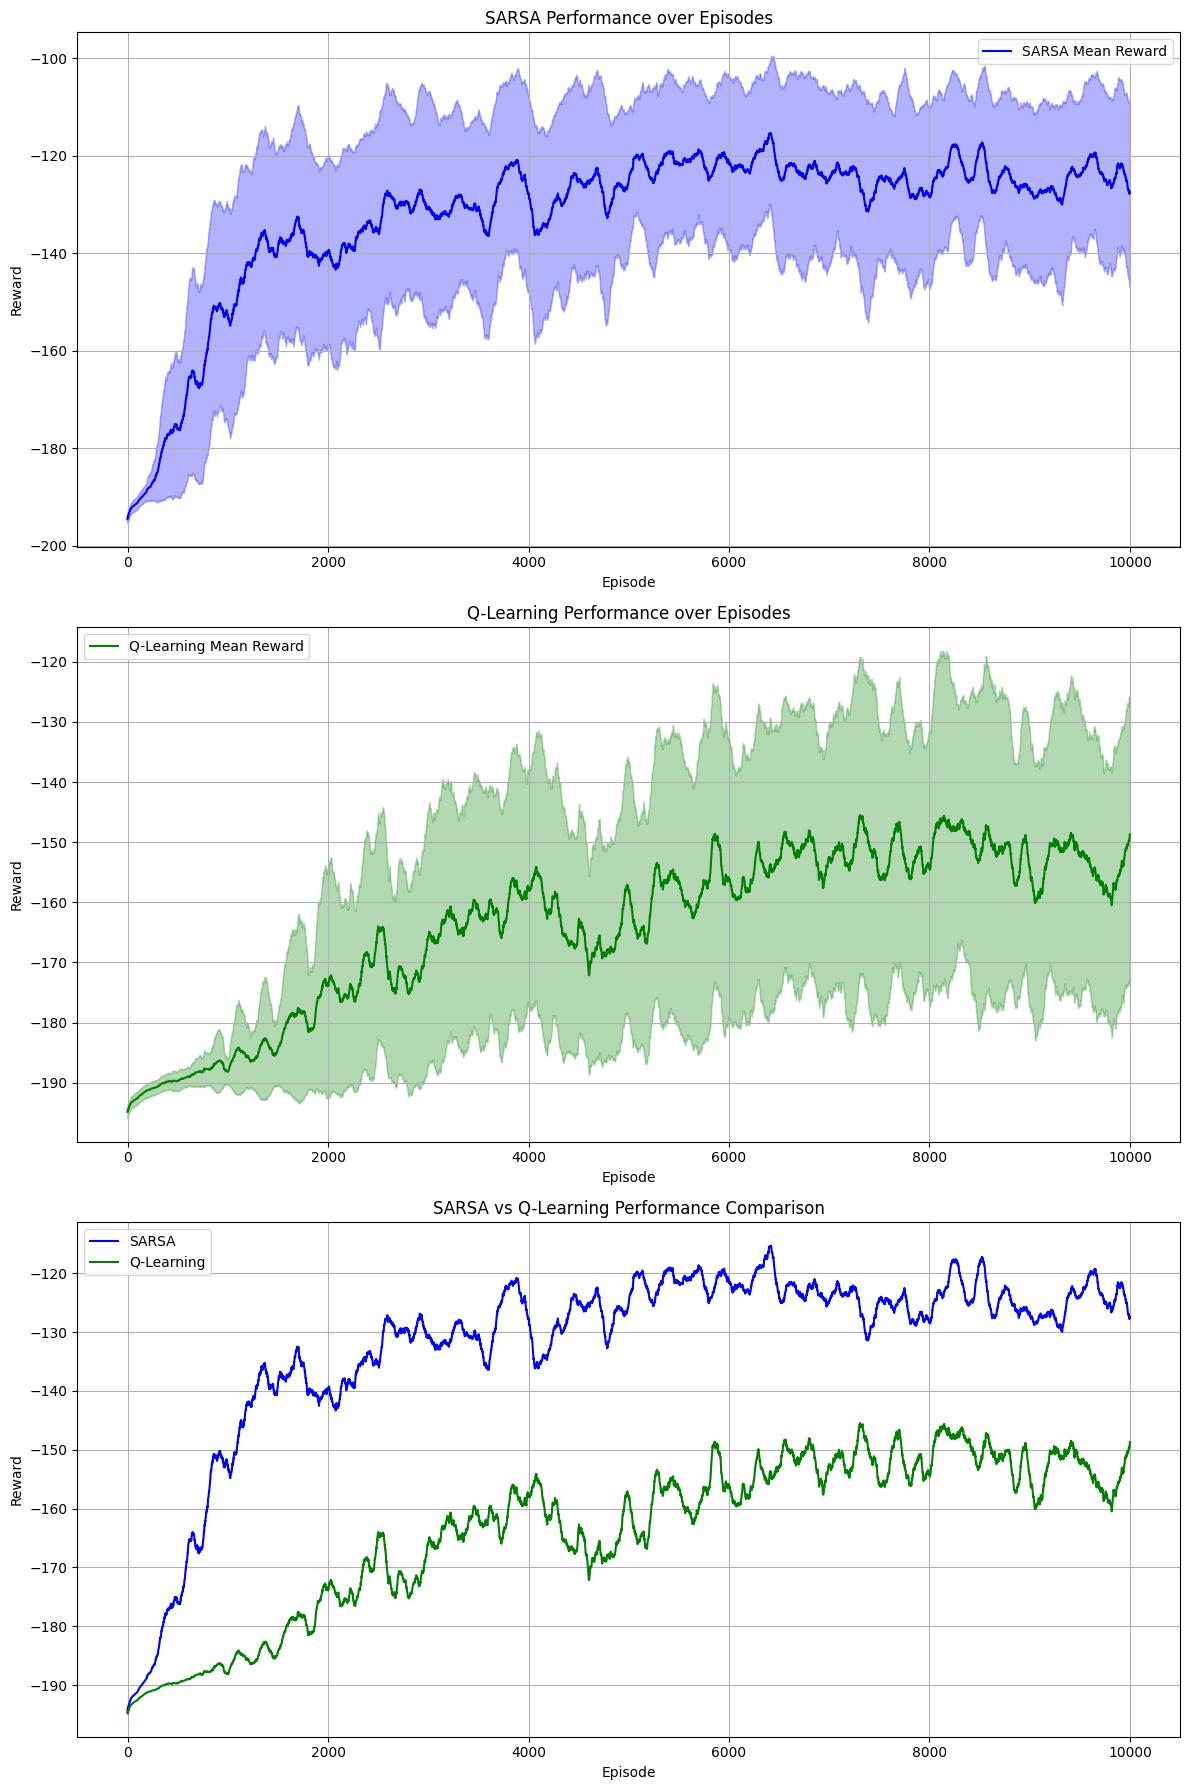

In [15]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    return seed

# Discretize the continuous state space for MountainCar
class StateDiscretizer:
    def __init__(self, n_bins=25):
        self.n_bins = n_bins
        # MountainCar-v0 state space bounds
        self.position_bins = np.linspace(-1.2, 0.6, n_bins)
        self.velocity_bins = np.linspace(-0.07, 0.07, n_bins)

    def discretize(self, state):
        position, velocity = state

        # Discretize each dimension
        position_bin = np.digitize(position, self.position_bins)
        velocity_bin = np.digitize(velocity, self.velocity_bins)

        # Combine into a single discrete state
        return (position_bin, velocity_bin)

# SARSA Agent with epsilon-greedy exploration
class SARSAAgent:
    def __init__(self, state_discretizer, action_space, alpha=0.2, gamma=0.99, epsilon=0.1):
        self.state_discretizer = state_discretizer
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))

    def select_action(self, state):
        state = self.state_discretizer.discretize(state)

        # Epsilon-greedy policy
        if np.random.random() < self.epsilon:
            return self.action_space.sample()  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update(self, state, action, reward, next_state, next_action, done):
        state = self.state_discretizer.discretize(state)
        next_state = self.state_discretizer.discretize(next_state)

        # SARSA update rule
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * self.q_table[next_state][next_action]

        # Update Q-value
        self.q_table[state][action] += self.alpha * (target_q - current_q)

# Q-Learning Agent with Softmax exploration
class QLearningAgent:
    def __init__(self, state_discretizer, action_space, alpha=0.2, gamma=0.99, temperature=0.8):
        self.state_discretizer = state_discretizer
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))

    def select_action(self, state):
        state = self.state_discretizer.discretize(state)

        # Softmax exploration
        q_values = self.q_table[state]
        exp_q = np.exp(q_values / self.temperature)
        probabilities = exp_q / np.sum(exp_q)

        # Sample action based on probabilities
        return np.random.choice(self.action_space.n, p=probabilities)

    def update(self, state, action, reward, next_state, done):
        state = self.state_discretizer.discretize(state)
        next_state = self.state_discretizer.discretize(next_state)

        # Q-Learning update rule
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state])

        # Update Q-value
        self.q_table[state][action] += self.alpha * (target_q - current_q)

# Evaluation function for SARSA
def evaluate_sarsa(best_params):
    # Fixed seeds
    seeds = [0, 1, 2, 3, 4]
    n_episodes = 10000
    all_rewards = []

    print("SARSA (Best):")

    for seed_idx, seed in enumerate(seeds):
        # Set environment
        env = gym.make("MountainCar-v0")

        # Set random seed
        set_seed(seed)

        # Initialize state discretizer
        state_discretizer = StateDiscretizer(n_bins=best_params['n_bins'])

        # Initialize SARSA agent
        agent = SARSAAgent(
            state_discretizer=state_discretizer,
            action_space=env.action_space,
            alpha=best_params['alpha'],
            gamma=best_params['gamma'],
            epsilon=best_params['epsilon']
        )

        # Training loop
        episode_rewards = []

        for episode in tqdm(range(n_episodes), desc=f"SARSA Seed {seed}"):
            state, _ = env.reset(seed=seed + episode)
            action = agent.select_action(state)
            done = False
            episode_reward = 0

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                # Apply enhanced reward shaping
                shaped_reward = reward
                if best_params['use_reward_shaping']:
                    position, velocity = next_state

                    # Reward for moving toward the goal (right side)
                    shaped_reward = reward

                    # Reward for gaining momentum (either direction)
                    shaped_reward += 0.1 * abs(velocity)

                    # Reward for position improvement
                    shaped_reward += 0.1 * position

                    # Additional reward for coordinated actions (moving right and pushing right)
                    if velocity > 0 and action == 2:
                        shaped_reward += 0.2

                    # Additional reward for coordinated actions (moving left and pushing left)
                    if velocity < 0 and action == 0:
                        shaped_reward += 0.2

                    # Bonus for reaching the goal
                    if terminated and position >= 0.5:
                        shaped_reward += 10

                episode_reward += shaped_reward

                # Select next action using current policy
                next_action = agent.select_action(next_state)

                # Update Q-values
                agent.update(state, action, shaped_reward, next_state, next_action, done)

                # Move to next state and action
                state = next_state
                action = next_action

            episode_rewards.append(episode_reward)

        # Calculate statistics
        mean_reward = np.mean(episode_rewards)
        reward_variance = np.var(episode_rewards)
        mean_regret = mean_reward  # In this case, regret is the same as reward
        regret_variance = reward_variance

        # Print statistics for this seed
        print(f"• Seed {seed}: {n_episodes}/{n_episodes} episodes, Mean Reward = {mean_reward:.2f}, "
              f"Reward Variance = {reward_variance:.2f}, Mean Regret = {mean_regret:.2f}, "
              f"Regret Variance = {regret_variance:.2f}.")

        all_rewards.append(episode_rewards)
        env.close()

    # Calculate final performance (mean of last 100 episodes across all seeds)
    final_rewards = [rewards[-100:] for rewards in all_rewards]
    mean_final_reward = np.mean([np.mean(rewards) for rewards in final_rewards])

    print(f"Final Performance Summary (SARSA): Mean Reward (last 100 episodes): {mean_final_reward:.2f}, "
          f"Mean Regret: {mean_final_reward:.2f}.")

    return all_rewards

# Evaluation function for Q-Learning
def evaluate_qlearning(best_params):
    # Fixed seeds
    seeds = [0, 1, 2, 3, 4]
    n_episodes = 10000
    all_rewards = []

    print("Q-Learning (Best):")

    for seed_idx, seed in enumerate(seeds):
        # Set environment
        env = gym.make("MountainCar-v0")

        # Set random seed
        set_seed(seed)

        # Initialize state discretizer
        state_discretizer = StateDiscretizer(n_bins=best_params['n_bins'])

        # Initialize Q-Learning agent
        agent = QLearningAgent(
            state_discretizer=state_discretizer,
            action_space=env.action_space,
            alpha=best_params['alpha'],
            gamma=best_params['gamma'],
            temperature=best_params['temperature']
        )

        # Training loop
        episode_rewards = []

        for episode in tqdm(range(n_episodes), desc=f"Q-Learning Seed {seed}"):
            state, _ = env.reset(seed=seed + episode)
            done = False
            episode_reward = 0

            while not done:
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                # Apply enhanced reward shaping
                shaped_reward = reward
                if best_params['use_reward_shaping']:
                    position, velocity = next_state

                    # Reward for moving toward the goal (right side)
                    shaped_reward = reward

                    # Reward for gaining momentum (either direction)
                    shaped_reward += 0.1 * abs(velocity)

                    # Reward for position improvement
                    shaped_reward += 0.1 * position

                    # Additional reward for coordinated actions (moving right and pushing right)
                    if velocity > 0 and action == 2:
                        shaped_reward += 0.2

                    # Additional reward for coordinated actions (moving left and pushing left)
                    if velocity < 0 and action == 0:
                        shaped_reward += 0.2

                    # Bonus for reaching the goal
                    if terminated and position >= 0.5:
                        shaped_reward += 10

                episode_reward += shaped_reward

                # Update Q-values
                agent.update(state, action, shaped_reward, next_state, done)

                # Move to next state
                state = next_state

            episode_rewards.append(episode_reward)

        # Calculate statistics
        mean_reward = np.mean(episode_rewards)
        reward_variance = np.var(episode_rewards)
        mean_regret = mean_reward  # In this case, regret is the same as reward
        regret_variance = reward_variance

        # Print statistics for this seed
        print(f"• Seed {seed}: {n_episodes}/{n_episodes} episodes, Mean Reward = {mean_reward:.2f}, "
              f"Reward Variance = {reward_variance:.2f}, Mean Regret = {mean_regret:.2f}, "
              f"Regret Variance = {regret_variance:.2f}.")

        all_rewards.append(episode_rewards)
        env.close()

    # Calculate final performance (mean of last 100 episodes across all seeds)
    final_rewards = [rewards[-100:] for rewards in all_rewards]
    mean_final_reward = np.mean([np.mean(rewards) for rewards in final_rewards])

    print(f"Final Performance Summary (Q-Learning): Mean Reward (last 100 episodes): {mean_final_reward:.2f}, "
          f"Mean Regret: {mean_final_reward:.2f}.")

    return all_rewards

# Plot results
def plot_results(sarsa_rewards, qlearning_rewards):
    n_episodes = len(sarsa_rewards[0])

    # Create figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Plot SARSA results
    sarsa_mean = np.mean(sarsa_rewards, axis=0)
    sarsa_std = np.std(sarsa_rewards, axis=0)

    # Smooth the curves using a rolling window
    window_size = 100
    sarsa_mean_smoothed = pd.Series(sarsa_mean).rolling(window=window_size, min_periods=1).mean().values
    sarsa_std_smoothed = pd.Series(sarsa_std).rolling(window=window_size, min_periods=1).mean().values

    episodes = np.arange(n_episodes)
    ax1.plot(episodes, sarsa_mean_smoothed, label='SARSA Mean Reward', color='blue')
    ax1.fill_between(episodes,
                    sarsa_mean_smoothed - sarsa_std_smoothed,
                    sarsa_mean_smoothed + sarsa_std_smoothed,
                    alpha=0.3, color='blue')
    ax1.set_title('SARSA Performance over Episodes')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.legend()
    ax1.grid(True)

    # Plot Q-Learning results
    qlearning_mean = np.mean(qlearning_rewards, axis=0)
    qlearning_std = np.std(qlearning_rewards, axis=0)

    # Smooth the curves
    qlearning_mean_smoothed = pd.Series(qlearning_mean).rolling(window=window_size, min_periods=1).mean().values
    qlearning_std_smoothed = pd.Series(qlearning_std).rolling(window=window_size, min_periods=1).mean().values

    ax2.plot(episodes, qlearning_mean_smoothed, label='Q-Learning Mean Reward', color='green')
    ax2.fill_between(episodes,
                    qlearning_mean_smoothed - qlearning_std_smoothed,
                    qlearning_mean_smoothed + qlearning_std_smoothed,
                    alpha=0.3, color='green')
    ax2.set_title('Q-Learning Performance over Episodes')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.legend()
    ax2.grid(True)

    # Comparative plot
    ax3.plot(episodes, sarsa_mean_smoothed, label='SARSA', color='blue')
    ax3.plot(episodes, qlearning_mean_smoothed, label='Q-Learning', color='green')
    ax3.set_title('SARSA vs Q-Learning Performance Comparison')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Reward')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('mountain_car_comparison.png')
    plt.show()

# Main evaluation function
def run_evaluation():
    # Best parameters from hyperparameter tuning (replace with your actual best parameters)
    sarsa_best_params = {
        'alpha': 0.26138,
        'gamma': 0.99,
        'epsilon': 0.051414,
        'n_bins': 25,
        'use_reward_shaping': True
    }

    qlearning_best_params = {
        'alpha': 0.25638,
        'gamma': 0.99,
        'temperature': 0.75339,
        'n_bins': 25,
        'use_reward_shaping': True
    }

    # Evaluate SARSA
    print("Evaluating SARSA...")
    sarsa_rewards = evaluate_sarsa(sarsa_best_params)

    # Evaluate Q-Learning
    print("\nEvaluating Q-Learning...")
    qlearning_rewards = evaluate_qlearning(qlearning_best_params)

    # Plot results
    print("\nPlotting results...")
    plot_results(sarsa_rewards, qlearning_rewards)

# Run the evaluation
if __name__ == "__main__":
    run_evaluation()


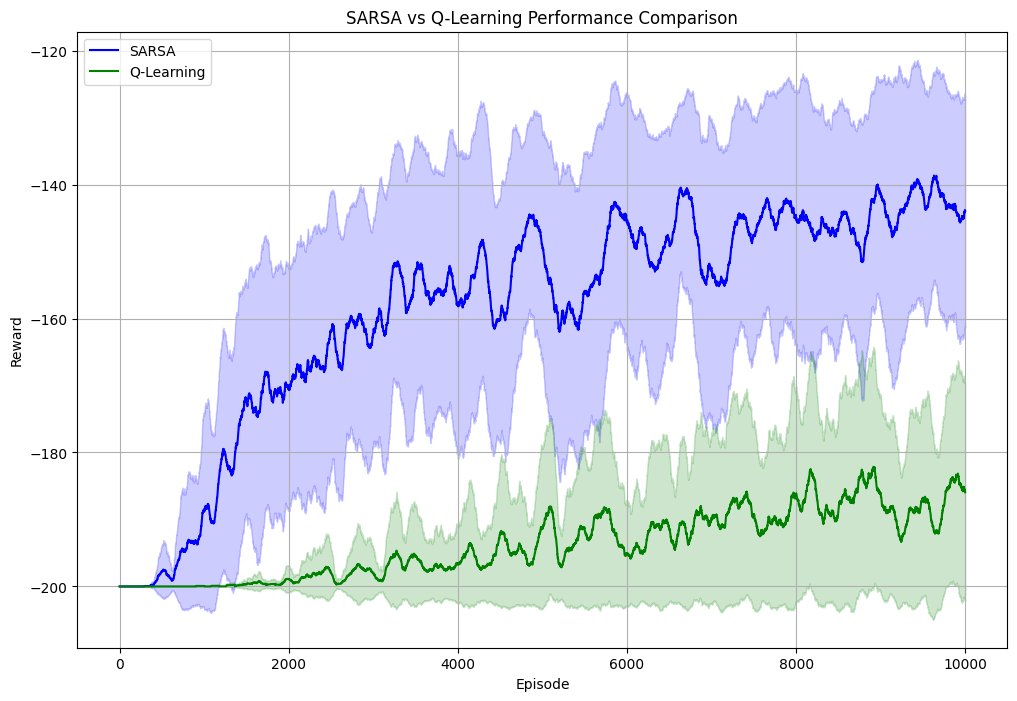

In [16]:
def create_comparative_plot(sarsa_rewards, qlearning_rewards):
    n_episodes = len(sarsa_rewards[0])
    episodes = np.arange(n_episodes)
    window_size = 100

    # Calculate statistics for SARSA
    sarsa_mean = np.mean(sarsa_rewards, axis=0)
    sarsa_std = np.std(sarsa_rewards, axis=0)
    sarsa_mean_smoothed = pd.Series(sarsa_mean).rolling(window=window_size, min_periods=1).mean().values
    sarsa_std_smoothed = pd.Series(sarsa_std).rolling(window=window_size, min_periods=1).mean().values

    # Calculate statistics for Q-Learning
    qlearning_mean = np.mean(qlearning_rewards, axis=0)
    qlearning_std = np.std(qlearning_rewards, axis=0)
    qlearning_mean_smoothed = pd.Series(qlearning_mean).rolling(window=window_size, min_periods=1).mean().values
    qlearning_std_smoothed = pd.Series(qlearning_std).rolling(window=window_size, min_periods=1).mean().values

    # Create the comparative plot
    plt.figure(figsize=(12, 8))

    # Plot SARSA with variance
    plt.plot(episodes, sarsa_mean_smoothed, label='SARSA', color='blue')
    plt.fill_between(episodes,
                    sarsa_mean_smoothed - sarsa_std_smoothed,
                    sarsa_mean_smoothed + sarsa_std_smoothed,
                    alpha=0.2, color='blue')

    # Plot Q-Learning with variance
    plt.plot(episodes, qlearning_mean_smoothed, label='Q-Learning', color='green')
    plt.fill_between(episodes,
                    qlearning_mean_smoothed - qlearning_std_smoothed,
                    qlearning_mean_smoothed + qlearning_std_smoothed,
                    alpha=0.2, color='green')

    plt.title('SARSA vs Q-Learning Performance Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)

    plt.savefig('sarsa_vs_qlearning_comparison.png')
    plt.show()

# After running the evaluation, add this line:
create_comparative_plot(sarsa_rewards, qlearning_rewards)


import wandb
wandb.login()
